# Decision Trees and Feature Importance
---

This notebook will briefly introduce a specific boosted decision tree model (LightGBMs), and then look at a method by which we can identify important factors and features within a dataset. 

1. [LightGBM](#lightgbm)
2. [Data Cleaning](#datacleaning)
3. [Model Building](#modelbuilding)
4. [Shapely Values](#shapely)

<a id='lightgbm'></a>

---
## LightGBM
---

LightGBM is a gradient boosting framework that uses tree based learning algorithms. 

It is popular for many reasons:

* Speed and GPU support.
* Ability to handle NaNs and categorical data efficiently. 

Finally, one of the main difference between LightGBM and other tree based algorithms is how the tree is grown. Most regular trees grow depth-wise (or level-wise):

<img src="../Images/level-wise.png" title="level-wise-growth" width="40%" height="40%" align="left"/>
<BR CLEAR="left">
    
However, LightGBM grows leaf-wise, which tend to reduce overfitting and increase speed of model building:
    
<img src="../Images/leaf-wise.png" title="level-wise-growth" width="40%" height="40%" align="left"/>
<BR CLEAR="left">

We implement a straightforward LightGBM model below, using the titanic dataset to attempt to classify the survival of the passengers. 

In [78]:
# Standard Stuff
import numpy as np
import pandas as pd

# Light GBM 
import lightgbm as lgb

# Shapely
import shap

# Metrics stuff
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve,
                             f1_score, auc, average_precision_score, matthews_corrcoef, recall_score, precision_score)

# Validation/preprocessing stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns

# Get rid of annoying stuff
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('../Data/titanic3.csv', skiprows=174)

In [79]:
display(df.head(10))
display(df.dtypes)
display(df.describe())

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.00,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.00,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.00,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.00,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.00,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


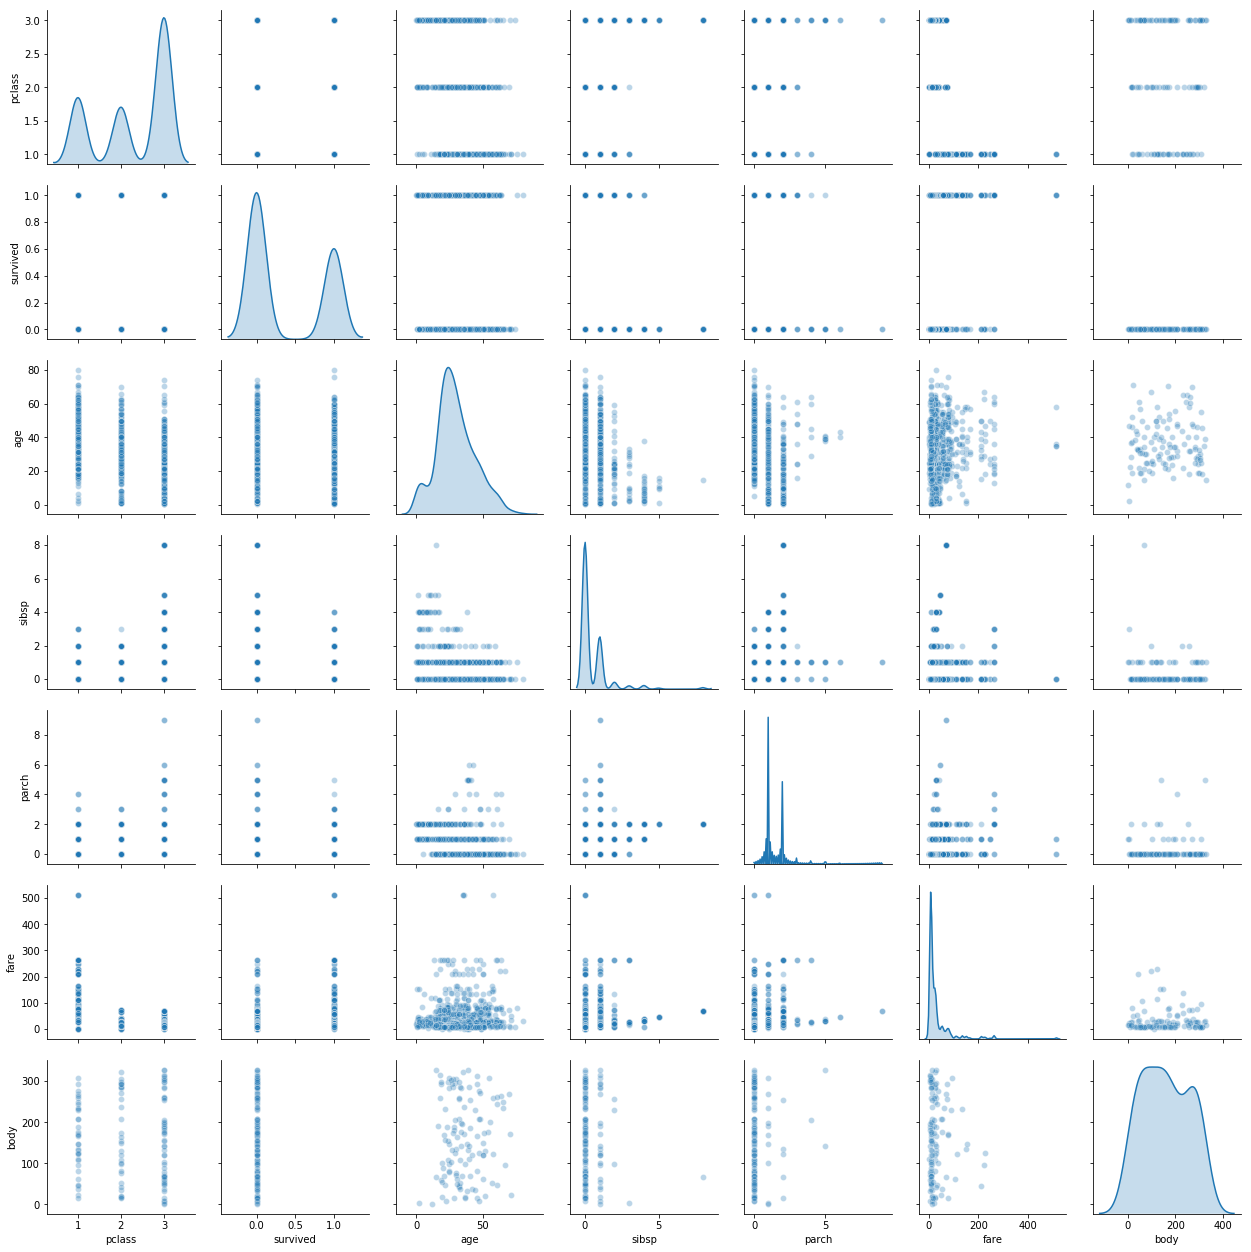

In [4]:
sns.pairplot(df, 
             #vars = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'survived'],
             #hue = 'survived', 
             plot_kws = {'alpha':0.3}, 
             diag_kind='kde')
plt.show()

In [5]:
cat = 'ticket'
display(df[cat].describe())

cat = 'home.dest'
display(df[cat].describe())

cat = 'name'
display(df[cat].describe())

display(df.columns)

count         1309
unique         929
top       CA. 2343
freq            11
Name: ticket, dtype: object

count              745
unique             369
top       New York, NY
freq                64
Name: home.dest, dtype: object

count                     1309
unique                    1307
top       Connolly, Miss. Kate
freq                         2
Name: name, dtype: object

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

<a id='datacleaning'></a>

---
## Data Cleaning
---

Before building our model, we need to refine the data:

* Some of the columns (such as body identification number) are added after the fact and can't really be used to predict survivability. 

* Other columns, such as 'name' will also not provide much useful information (we could possibly, for example, extract their title, or surname, etc, but let's keep it simple for now). 

* Many of the columns are categorical, and need to be treated as such. However, we don't want one category to have 100's of options. So for instance, we remove the cabin category and replace it with deck (first letter of the cabin). 

* The numerical columns can be left alone. I don't even think they need to be normalized for decision trees...

In [6]:
# Some of these have 100% correlation with the prediction, so we need to remove a few of the columns to prevent data leakage
data_leakage_columns = ['body',
                        'boat']

# Some are just not important, like the name of the person
# ticket ends up with over 900 categories, so removing
# home.dest may also be less useful as they end up with 100s of categories. 
uninformative_columns = ['name', 
                         'ticket',
                         'home.dest']

# Relabel categorical columns with integers

# not sure how to label some of these:

# pclass = passenger class, so categorical will be fine
# sex = also fine categorical
# cabin = cabin aboard, ends up with many categories, might be worth just splitting on the first letter? (ie the deck)
# embarked = where they got on, fine categorical
# home.dest = home/destination, has many options. maybe split into home and destination as two different categories?
# ticket is also a strange one... I think it will be best to drop it as it ends up with 900+ categories otherwise
categorical_columns = ['pclass', 
                       'sex', 
                       'embarked', 
                       'deck']

# let's keep a list of the numerical columns as well
# age = self explanatory
# sibssp = # siblings aboard
# parch = # parents aboard
# fare = fare
numerical_columns = ['age',
                    'sibsp',
                    'parch',
                    'fare']

# what we are trying to predict
target_str = 'survived'

In [7]:
df_no_leak = df.drop(data_leakage_columns, axis=1)
df_informative = df_no_leak.drop(uninformative_columns, axis=1)
df_informative['deck'] = df_informative['cabin'].copy()

# Add the deck categorical variable
for idx in range(df_informative.shape[0]):
    cabin = df_informative.loc[idx,'cabin']
    if pd.isna(cabin):
        df_informative.loc[idx, 'deck']=cabin
    else:
        df_informative.loc[idx, 'deck']=cabin[0]

# Remove the cabin variable
df_informative = df_informative.drop(['cabin'], axis=1)

# Convert to categorical the appropriate columns (and make sure the type is int)
# Note that for lgbm, we don't need to one hot encode, but just keep track of which columns are categorical. 
for cat in categorical_columns:
    df_informative[cat] = df_informative[cat].astype('category')
    df_informative[cat+'_cat'] = df_informative[cat].cat.codes
    # keep the nans (because the lightGBM method will actually deal with this?)
    # note: lgbm treats negative values as missing, so don't need to replace the -1
    df_informative[cat+'_cat'] = df_informative[cat+'_cat'].astype('category')
    #df_informative[cat+'_cat'] = df_informative[cat+'_cat'].replace(-1, np.nan)
    

# Rename categorical columns back to their originals
df_final = df_informative.drop(categorical_columns, axis=1)
for cat in categorical_columns:
    df_final = df_final.rename(index=str, columns={cat+'_cat': cat})

In [8]:
# To see the categorical mapping:
for cat in categorical_columns:
    print(cat)
    print(dict(enumerate(df_informative[cat].cat.categories )))
    print()

pclass
{0: 1, 1: 2, 2: 3}

sex
{0: 'female', 1: 'male'}

embarked
{0: 'C', 1: 'Q', 2: 'S'}

deck
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'T'}



In [9]:
display(df_final.head(10))
display(df_final.dtypes)

,survived,age,sibsp,parch,fare,pclass,sex,embarked,deck
0,1,29.00,0,0,211.3375,0,0,2,1
1,1,0.92,1,2,151.5500,0,1,2,2
2,0,2.00,1,2,151.5500,0,0,2,2
3,0,30.00,1,2,151.5500,0,1,2,2
4,0,25.00,1,2,151.5500,0,0,2,2
5,1,48.00,0,0,26.5500,0,1,2,4
6,1,63.00,1,0,77.9583,0,0,2,3
7,0,39.00,0,0,0.0000,0,1,2,0
8,1,53.00,2,0,51.4792,0,0,2,2
9,0,71.00,0,0,49.5042,0,1,0,-1


survived       int64
age          float64
sibsp          int64
parch          int64
fare         float64
pclass      category
sex         category
embarked    category
deck        category
dtype: object

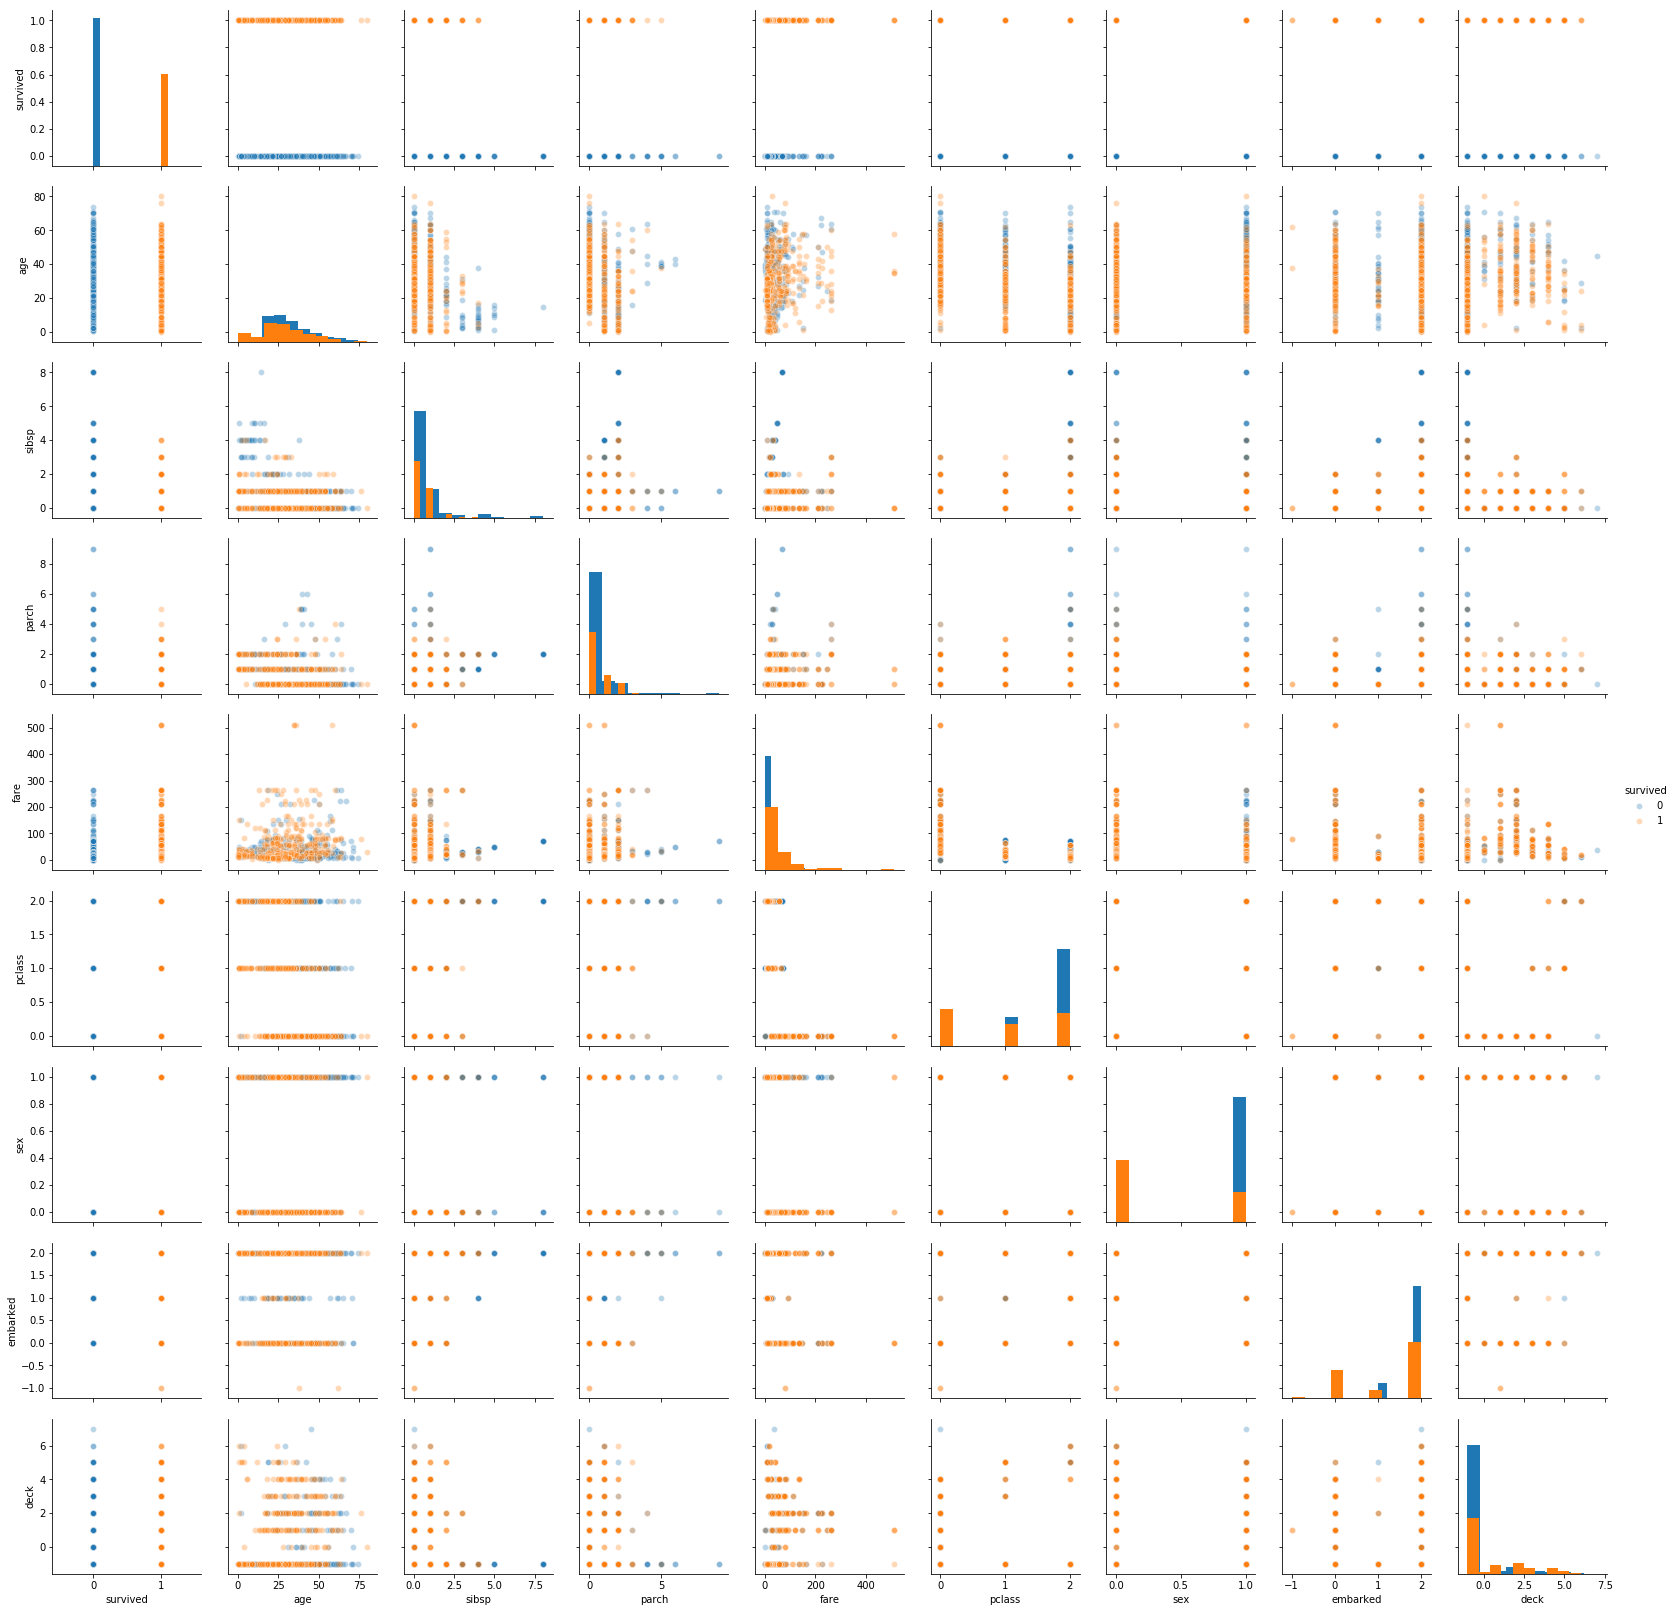

In [10]:
sns.pairplot(df_final, 
             hue = target_str,
             plot_kws = {'alpha':0.3}, 
             diag_kind='hist')
plt.show()

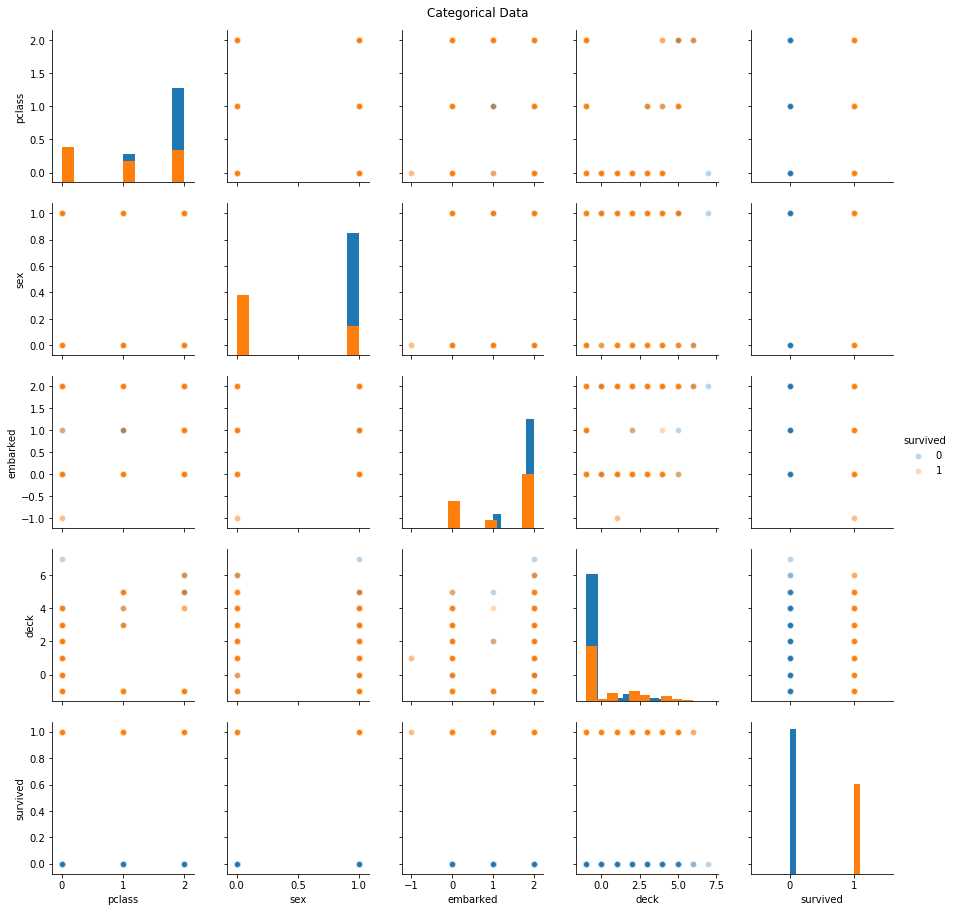

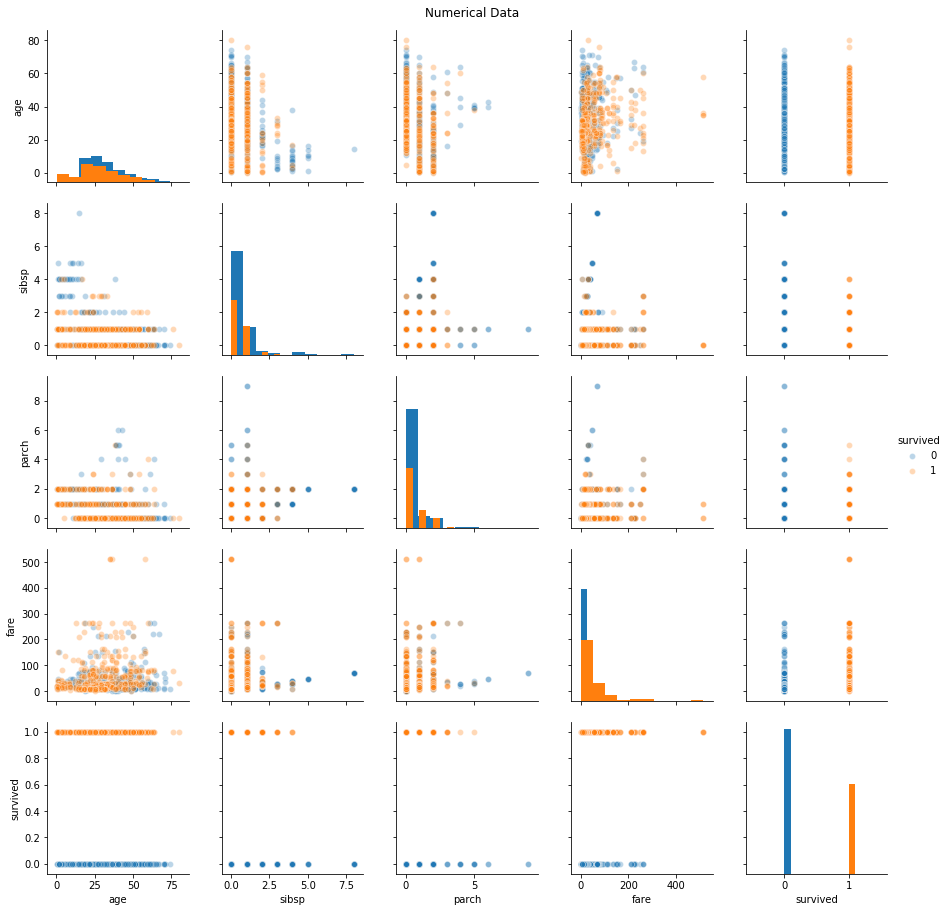

In [124]:
sns.pairplot(df_final, 
             vars = categorical_columns + [target_str],
             hue = target_str,
             plot_kws = {'alpha':0.3}, 
             diag_kind='hist')
plt.suptitle('Categorical Data', y=1.01)
plt.show()

sns.pairplot(df_final, 
             vars = numerical_columns + [target_str],
             hue = target_str,
             plot_kws = {'alpha':0.3}, 
             diag_kind='hist')
plt.suptitle('Numerical Data', y=1.01)
plt.show()

<a id='modelbuilding'></a>

---
## Model Building
---

Now that we have cleaned the data, we can build our model. To do this we need a few extra pieces:

1. Custom Metrics. 
    * The built in metrics for LightGBM don't include much past the decision error.
    * As such, we build a custom method that will determine things like f1, mcc, accuarcy, etc. 
    * Also use my standard ModelMetrics class at the end. 
2. Build LightGBM datasets.
    * LightGBM has its own dataset api that should be uesd when inputting data into your predictor.
    * Here you need to identify which of the rows are categorical. 
3. Set up model parameters.
    * The model has *many* parameters that can be set.
    * Some of the standard decision tree models that can be varied include number of leaves, number of trees, max depth, etc.
4. Creating a model.
    * LightGBM has two ways to build a model: 
        * you can directly use their cv method to get average metric values, or
        * simply build a model, where you can use both a train and validation/test set. 
5. Predict and visualize.
    * LightGBM has many visualizations built in. Some of these are explored below.

In [21]:
# custom metrics
def custom_scores(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    f1 = f1_score(y_true,y_hat)
    mcc = matthews_corrcoef(y_true,y_hat)
    acc = np.mean(y_true==y_hat)
    
    # return a list of tuples with a string for the name, the score, and whether larger=better
    return [('f1', f1, True),
           ('mcc', mcc, True),
           ('acc',acc, True)]

class ModelMetrics():
    """
        ModelMetrics class that will provide many different metrics for a given model outputs. 

        Required Parameters:
        y_test = Test Data Classes. Should be either (-1,1) or (0,1).
        y_pred = Predictions for the "probability" of y being in the positive class. Should be in range (-inf,inf)
        y_prob = Test Data Predictions from the model. Should be same format as y_test. 

        Useful functions:
        all_metrics() = returns metrics including: class imbalance, 
                                                   accuracy,
                                                   confusion matrix,
                                                   ROC/AUC,
                                                   Precision/Recall Curve, F1 score, MCC, AUC, Average Precision
        
    """
    
    def __init__(self,y_test,y_pred,y_prob):
        self.y_test = np.array(y_test).reshape(-1)
        self.y_pred = np.array(y_pred).reshape(-1)
        self.y_prob = np.array(y_prob).reshape(-1)
        
    def all_metrics(self):
        print('')
        self.imbalance()
        print('')
        self.accuracy()
        print('')
        self.print_cm()
        print('')
        self.roc_metrics()
        print('')
        self.pr_metrics()
        
    def roc_metrics(self):
        self.roc_plot()
        self.print_auc_roc()
        
    def pr_metrics(self):
        self.plot_pr()
        self.print_f1()
        self.print_mcc()
        self.print_auc_pr()
        self.print_ap()
        
    # Measure Imbalance
    def imbalance(self):
        num_examples = len(self.y_test)
        y_min = min(self.y_test)
        y_max = max(self.y_test) 
        num_neg = np.sum(self.y_test==y_min)
        num_pos = np.sum(self.y_test==y_max)
        print("Number of negative cases = ",num_neg)
        print("Number of positive cases = ",num_pos)
        print('The ratio of Positve to Negative cases is {:0.3f}'.format(num_pos/num_neg))
        
        print('')
        if num_neg/num_pos >= 2:
            print('Number of Negative Classes is quite large. Recommend using the Precision-Recall Metrics.')
        elif num_pos/num_neg >=2:
            print('Number of Positive Classes is quite large. Recommend using the Precision-Recall Metrics.')
        else:
            print('The classes seem balanced. ROC metrics should be acceptable.')
        print('')
    
    # Overall accuracy
    def accuracy(self):
        acc = accuracy_score(self.y_test,self.y_pred)
        print('Overall Accuracy = {:0.3f}'.format(acc))
        return acc
        
    # Confusion Matrix
    def print_cm(self):
        cm = confusion_matrix(self.y_test,self.y_pred)
        true_negative, false_positive, false_negative, true_positive = cm.ravel()
        print('           CONFUSION MATRIX')
        print('                 y_pred')
        print('          {:^10d}{:^10d}'.format(-1,1))
        print('           --------------------')
        print('y_test -1 |{:^10d}{:^10d}|'.format(true_negative,false_positive))
        print('        1 |{:^10d}{:^10d}|'.format(false_negative,true_positive))
        print('           --------------------')
        return cm
        
    # ROC Curve
    def roc_plot(self):
        false_positive_rate, true_positive_rate, thresholds = roc_curve(self.y_test,self.y_prob)
        plt.plot(false_positive_rate,true_positive_rate,'-b',label='Model')
        plt.plot([0,1],[0,1],'-k',label='Guess')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([-0.02,1.0])
        plt.ylim([0.0,1.02])
        plt.legend()
        plt.show()

    # AUC of ROC
    def print_auc_roc(self):
        auc1 = roc_auc_score(self.y_test,self.y_prob)
        print('AUC = {:0.3f}'.format(auc1))
        return auc1

    ## These next few are more useful for imbalanced classes 

    # Precision - Recall Curve
    def plot_pr(self):
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_prob)
        plt.plot(recall,precision,'-b',label='Model')
        plt.plot([0,1],[0.5,0.5],'-k',label='Guess')
        plt.title('Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim([-0.02,1.0])
        plt.ylim([0.0,1.02])
        plt.legend()
        plt.show()

    # F1 Score
    def print_f1(self):
        f1 = f1_score(self.y_test,self.y_pred)
        print("F1 Score = {:0.3f}".format(f1))
        return f1
    
    # Matthews Correlation
    def print_mcc(self):
        mcc = matthews_corrcoef(self.y_test,self.y_pred)
        print("MCC = {:0.3f}".format(mcc))
        return mcc

    # AUC for PR
    def print_auc_pr(self):
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_prob)
        auc2 = auc(recall,precision)
        print("AUC for Precision-Recall: {:0.3f}".format(auc2))
        return auc2

    # Average precision
    def print_ap(self):
        average_precision = average_precision_score(self.y_test,self.y_prob)
        print("Average Precision = {:0.3f}".format(average_precision))
        return average_precision

In [53]:
# Now we start building the model...
df_train, df_test = train_test_split(df_final, test_size = 0.15, random_state = 42)

# scale the numerical columns? not really necessary
scaler = StandardScaler()
for feature in numerical_columns:
    df_train.loc[:,feature]=scaler.fit_transform(df_train.loc[:,feature].values.reshape(-1,1))
    df_test.loc[:,feature]=scaler.transform(df_test.loc[:,feature].values.reshape(-1,1))

data_train = lgb.Dataset(df_train[categorical_columns + numerical_columns], 
                   label = df_train[target_str],
                   feature_name=categorical_columns+numerical_columns,
                   categorical_feature=categorical_columns)

#x_train = data_train.get_data()
#y_train = data_train.get_label()

data_test = lgb.Dataset(df_test[categorical_columns + numerical_columns], 
                   label = df_test[target_str],
                   feature_name=categorical_columns+numerical_columns,
                   categorical_feature=categorical_columns)

#x_test = data_test.get_data()
#y_test = data_test.get_label()

In [48]:
# set useful model parameters
params = {}

# fixed things
params['objective']='binary' # We are doing a binary classification, can't change this
params['metric']=['binary_logloss', 'binary_error'] # interesting metrics to follow
params['boosting_type']='gbdt' # type of boosting to use 

# prevent overfitting - main things to play with in the trees
params['num_leaves']=20 # max leaves for any tree, can help with overfitting (default 31)
params['max_depth']=20 # helps with overfitting to only allow trees to grow so deep (default -1)
params['min_data_in_leaf']=20 # minimal number of data in one leaf (default 20)

# faster 
params['bagging_fraction']=0.9 # randomly select part of data without resampling, can speed up/stop overfitting (default 1)
params['feature_fraction']=0.9 # only use part of features on each iteration (default 1)
params['early_stopping_round']=0 # will stop training if one metric of one validation data doesn’t improve (default 0)

# better accuracy
params['num_trees']=200 # total number of trees to boost over (sort of like # of iterations) (deafault 100)
params['learning_rate']=0.05 # learning rate..? (default 0.1)

# regularization
params['lambda_l1']=0.0 # L1 regularization (default 0)
params['lambda_l2']=0.0 # L2 regularization (default 0)
params['min_gain_to_split']=0.0 # minimal gain to perform a split (default 0)

In [84]:
# loop over k-fold CV to get best hyperparameters
nfold = 5
num_leaves_list = [5, 10, 15, 20, 25, 30, 35, 40]
max_depth_list = [5, 10, 15, 20, 25, 30, 35, 40]
num_trees_list = [50, 100, 150, 200, 250, 300]

num_leaves_best = 0
max_depth_best  = 0
num_trees_best  = 0

metric = 'mcc'
best_metric = 0

for num_leaves in num_leaves_list:
    for max_depth in max_depth_list:
        for num_trees in num_trees_list:
            params['num_leaves']=num_leaves
            params['max_depth']=max_depth
            params['num_trees']=num_trees
            
            
            cv_evals = lgb.cv(params, 
                              data_train, 
                              categorical_feature=categorical_columns,
                              nfold=nfold,
                              stratified=True,
                              shuffle=True,
                              feval=custom_scores,
                              verbose_eval=False)
            
            final_metric = cv_evals[metric+'-mean'][-1]
            if final_metric>best_metric:
                best_metric=final_metric
                num_leaves_best=num_leaves
                max_depth_best=max_depth
                num_trees_best=num_trees
            
            print('\rnum_leaves = {:d} ** max_depth = {:d} ** num_trees = {:d} ** metric = {:0.3f}'.format(num_leaves, max_depth, num_trees, final_metric), end='')
            
print('\nThe best values determined from 5-fold CV are:\n')
print('Number of leaves: {:d}'.format(num_leaves_best))
print('Max depth:        {:d}'.format(max_depth_best))
print('Number of trees:  {:d}'.format(num_trees_best))
print('\nBest {:s} metric value: {:0.3f}'.format(metric,best_metric))

num_leaves = 40 ** max_depth = 40 ** num_trees = 300 ** metric = 0.625

In [90]:
params['num_leaves']=num_leaves_best
params['max_depth']=max_depth_best
params['num_trees']=num_trees_best

cv_evals = lgb.cv(params, 
                  data_train, 
                  categorical_feature=categorical_columns,
                  nfold=nfold,
                  stratified=True,
                  shuffle=True,
                  feval=custom_scores,
                  verbose_eval=False)

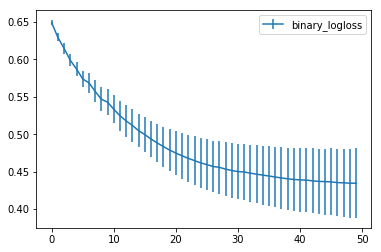

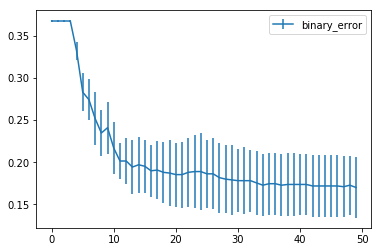

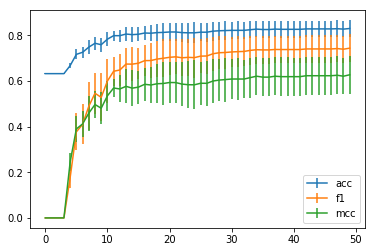

In [91]:
to_plot = 'binary_logloss'
plt.errorbar(range(len(cv_evals[to_plot+'-mean'])), 
             cv_evals[to_plot+'-mean'],
             yerr=cv_evals[to_plot+'-stdv'],
             label=to_plot)
plt.legend()
plt.show()

to_plot = 'binary_error'
plt.errorbar(range(len(cv_evals[to_plot+'-mean'])), 
             cv_evals[to_plot+'-mean'],
             yerr=cv_evals[to_plot+'-stdv'],
             label=to_plot)
plt.legend()
plt.show()


to_plot = 'acc'
plt.errorbar(range(len(cv_evals[to_plot+'-mean'])), 
             cv_evals[to_plot+'-mean'],
             yerr=cv_evals[to_plot+'-stdv'],
             label=to_plot)

to_plot = 'f1'
plt.errorbar(range(len(cv_evals[to_plot+'-mean'])), 
             cv_evals[to_plot+'-mean'],
             yerr=cv_evals[to_plot+'-stdv'],
             label=to_plot)

to_plot = 'mcc'
plt.errorbar(range(len(cv_evals[to_plot+'-mean'])), 
             cv_evals[to_plot+'-mean'],
             yerr=cv_evals[to_plot+'-stdv'],
             label=to_plot)
plt.legend()
plt.show()

In [92]:
# After using CV to determine optimal hyperparameters, do a final training iteration to use for shapely values. 
evals_result = {}
bst = lgb.train(params, 
                data_train, 
                categorical_feature=categorical_columns, 
                valid_sets = [data_train, data_test],
                valid_names = ['train', 'test'],
                feval=custom_scores,
                evals_result=evals_result,
                verbose_eval=False)

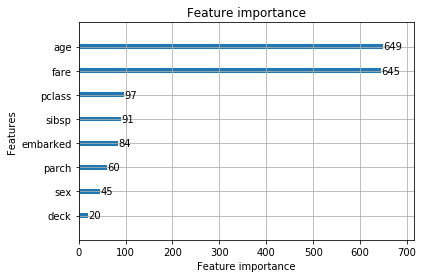

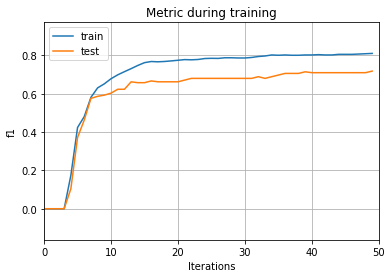

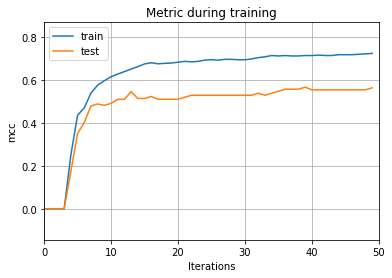

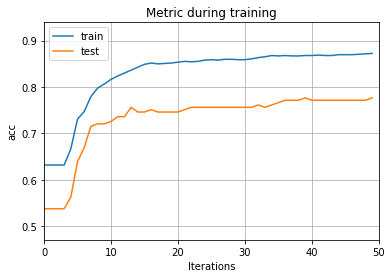

In [93]:
lgb.plot_importance(bst)
plt.show()

lgb.plot_metric(evals_result, metric='f1')
lgb.plot_metric(evals_result, metric='mcc')
lgb.plot_metric(evals_result, metric='acc')
plt.show()

In [302]:
# create visualizations of the trees
dot = lgb.create_tree_digraph(bst)
dot.render('test.gv', view=True)  

'test.gv.pdf'

In [107]:
x_train = df_train[categorical_columns + numerical_columns]
y_train = df_train[target_str]

x_test = df_test[categorical_columns + numerical_columns]
y_test = df_test[target_str]
y_prob = bst.predict(x_test)
y_pred = np.round(y_prob)


Number of negative cases =  106
Number of positive cases =  91
The ratio of Positve to Negative cases is 0.858

The classes seem balanced. ROC metrics should be acceptable.


Overall Accuracy = 0.777

           CONFUSION MATRIX
                 y_pred
              -1        1     
           --------------------
y_test -1 |    97        9     |
        1 |    35        56    |
           --------------------



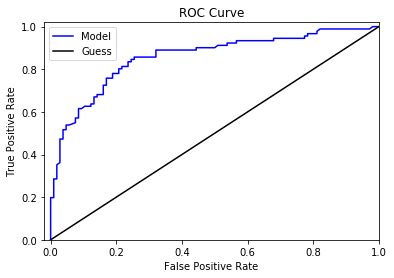

AUC = 0.857



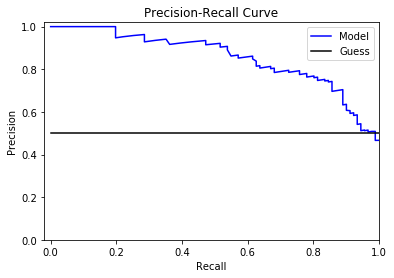

F1 Score = 0.718
MCC = 0.562
AUC for Precision-Recall: 0.855
Average Precision = 0.855


In [108]:
metrics = ModelMetrics(y_test, y_pred, y_prob)
metrics.all_metrics()

<a id='shapely'></a>

---
## Shapely Values
---

The Shapely value can be used to help infer the importance of both features and factors within features towards predicting the outcome of a model. The larger a Shapely value, the more positive a feature/factor is driving the response. 

The SHAP module can be automatically used with most tree ensemble programs (LightGBM, xgboost, sklearn).

The following pieces of code can be used to create various Shapely visualizations. 

<img src="../Images/shap_diagram.png" title="shap-diagram" width="40%" height="40%" align="left"/>
<BR CLEAR="left">

In [96]:
# Now let's work on the Shapely Values
shap.initjs()
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(x_train)

In [97]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

In [98]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, x_train)

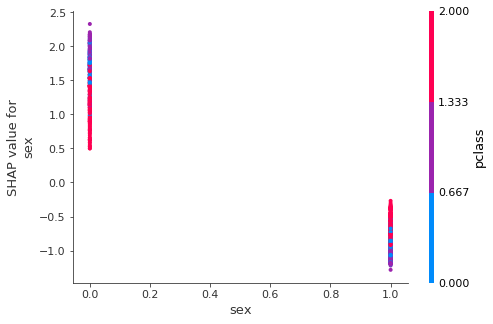

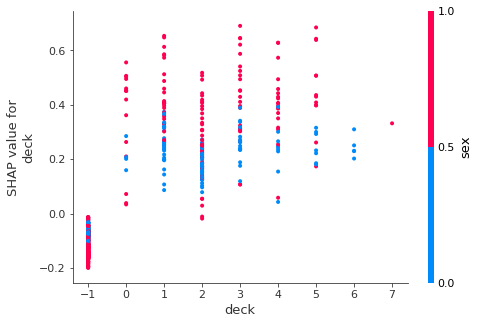

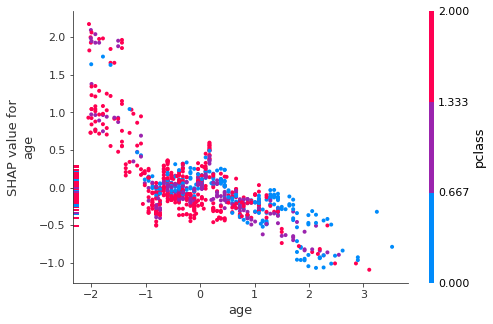

In [104]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
# seems to arbitrarily choose a coloring feature

# categorical feature
feature = 'sex'
shap.dependence_plot(feature, shap_values, x_train)

feature = 'deck'
shap.dependence_plot(feature, shap_values, x_train)

# numerical feature
feature = 'age'
shap.dependence_plot(feature, shap_values, x_train)

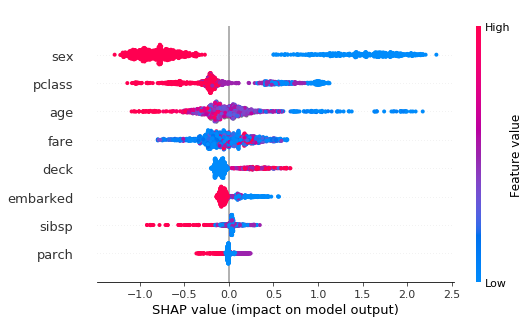

In [100]:
# summarize the effects of all the features
shap.summary_plot(shap_values, x_train)

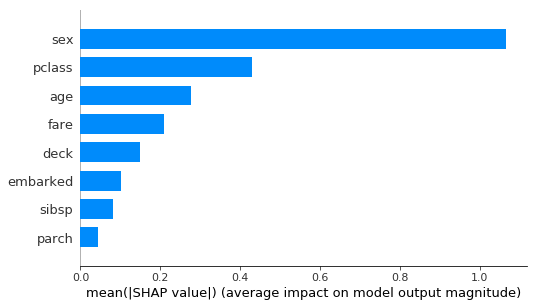

In [101]:
# take the mean absolute value of the SHAP values for each feature to get a standard bar plot
shap.summary_plot(shap_values, x_train, plot_type="bar")

This all seems to indicate that sex is an important indicator for who survived, and women tended to survive much more than men. This makes sense if we look at the data: only 38% of people survived, while 73% of the women survived. 

In [122]:
np.mean(df_informative[df_informative['sex']=='female']['survived']==1)

0.7274678111587983

In [121]:
np.mean(df_informative['survived']==1)

0.3819709702062643

In [125]:
np.mean(df_informative[df_informative['sex']=='male']['survived']==1)

0.19098457888493475